In [93]:
import torch
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def read_data(path):
    full_data = pd.read_excel(path)
    full_data.drop(columns=[1], axis=1, inplace=True)
    return full_data

full_data = read_data("./data/relative_wages_communes.xlsx")
target = full_data[2021]
full_X = full_data.drop(columns=[2021], axis=1)
X_train_all, X_test, y_train_all, y_test = train_test_split(full_X, target, train_size=0.8, shuffle=True, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, train_size=0.8, shuffle=True, random_state=42)

In [95]:
X_train, y_train = X_train.to_numpy(), y_train.to_numpy()
X_train = X_train.reshape((-1, 9, 1))
y_train = y_train.reshape((-1, 1))
X_val, y_val = X_val.to_numpy(), y_val.to_numpy()
X_val = X_val.reshape((-1, 9, 1))
y_val = y_val.reshape((-1, 1))
X_test, y_test = X_test.to_numpy(), y_test.to_numpy()
X_test = X_test.reshape((-1, 9, 1))
y_test = y_test.reshape((-1, 1))

In [52]:
def get_dataloader(X,y, batch_size, shuffle ):
    # fill your code
    train_x_tensor = torch.tensor(X, dtype=torch.float)
    train_y_tensor = torch.tensor(y, dtype=torch.float)
    train_tensor_dataset = torch.utils.data.TensorDataset(train_x_tensor, train_y_tensor)
    dataloader = torch.utils.data.DataLoader(train_tensor_dataset,
                                             batch_size=batch_size,
                                             shuffle=shuffle)
    return dataloader

In [53]:
train_dataloader = get_dataloader(X_train, y_train, batch_size = 16, shuffle=True)
val_dataloader = get_dataloader(X_val, y_val, batch_size = y_val.shape[0], shuffle=False)
test_dataloader = get_dataloader(X_test, y_test, batch_size = y_test.shape[0], shuffle=True)

In [60]:
class NeuralNetwork(torch.nn.Module):
    """
    Simple two layer neural network for regression
    """
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                                  num_layers=num_layers, batch_first=True)
        self.forecast = torch.nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.forecast(out[:, -1, :])
        return out

In [61]:
lstm_model = NeuralNetwork(1, 4, 1)

In [62]:
# -------------------- Training  Step----------------------------
def training_step(model, input_data, optimizer, loss_fn):
    # reset gradients of the optimizer
    optimizer.zero_grad()

    # unfold data
    x_batch, y_batch = input_data

    # get predictions
    y_pred = model(x_batch)

    # calculate loss
    loss = loss_fn(y_pred, y_batch)

    # compute gradients 
    loss.backward()

    # optimise network
    optimizer.step()

    return loss.data.numpy()

In [63]:
def evaluation_step(model, input_data, loss_fn):
    # when we use torch.no_grad pytorch doesn't store information
    # that is required to calculate gradients so is faster
    with torch.no_grad():
        x_batch, y_batch = input_data
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)

    return loss.data.numpy()

In [64]:
import time


# -------------------- Train  Loop----------------------------
def train_loop(train_dataloader, val_dataloader, patient, epochs, model, optimizer, loss_fn):
    best_loss = np.inf
    consecutive_epoch = 0
    best_epoch = 0

    train_history = []
    val_history = []
    for epoch in range(epochs): # iterate over epoch    

        # -------------------- Training on each epoch ----------------------------
        total_step = len(train_dataloader)
        accumulated_loss = 0 # monitor loss during training
        start = time.time()
        for step in range(total_step): # iterate over batch
            batch_data = next(iter(train_dataloader)) # get a batch
            loss = training_step(model,batch_data,optimizer,loss_fn) # train model using a single batch
            accumulated_loss = (step * accumulated_loss + loss)/(step+1)
        end = time.time()
        total_time = end - start
        train_history += [{"loss":accumulated_loss, "epoch": epoch, "set":"train"}]

        # -------------------- Monitor Error Validation set ----------------------------
        val_data = next(iter(val_dataloader))
        val_loss = evaluation_step(model, val_data, loss_fn)
        val_history += [{"loss":val_loss, "epoch": epoch, "set":"val"}]
        if epoch % 1 == 0:
            print(f"Epoch {epoch}/{epochs}:({total_time:.3f} sec)  loss:{accumulated_loss:.3f}, val_loss:{val_loss:.3f}")

        # -------------------- Early Stoping ----------------------------
        if val_loss > best_loss:
            consecutive_epoch += 1
        else:
            best_loss = val_loss # we have an improvement
            consecutive_epoch = 0 # reset counter
            best_epoch = epoch
            best_weights = model.state_dict()

        if consecutive_epoch > patient:
            break
    val_history_df = pd.DataFrame(val_history)
    train_history_df = pd.DataFrame(train_history)
    return model, val_history_df, train_history_df, best_loss, best_epoch, best_weights

In [65]:
lr = 0.001


optimizer = torch.optim.Adam(lstm_model.parameters(), lr=lr)
loss_fn = torch.nn.MSELoss()

out = train_loop(train_dataloader = train_dataloader,
                 val_dataloader = val_dataloader,
                 patient = 3,
                 epochs = 10,
                 model = lstm_model,
                 optimizer= optimizer,
                 loss_fn= loss_fn)

model, val_history_es_5, train_history_es_5, best_loss, best_epoch, best_weights = out

Epoch 0/10:(0.889 sec)  loss:0.034, val_loss:0.003
Epoch 1/10:(0.718 sec)  loss:0.003, val_loss:0.003
Epoch 2/10:(0.692 sec)  loss:0.002, val_loss:0.002
Epoch 3/10:(0.686 sec)  loss:0.002, val_loss:0.002
Epoch 4/10:(0.706 sec)  loss:0.002, val_loss:0.001
Epoch 5/10:(0.717 sec)  loss:0.001, val_loss:0.001
Epoch 6/10:(0.682 sec)  loss:0.001, val_loss:0.001
Epoch 7/10:(0.683 sec)  loss:0.001, val_loss:0.001
Epoch 8/10:(1.012 sec)  loss:0.001, val_loss:0.001
Epoch 9/10:(0.666 sec)  loss:0.001, val_loss:0.001


In [66]:
test_data = next(iter(test_dataloader))
loss = evaluation_step(lstm_model, test_data, loss_fn)

In [67]:
loss

array(0.00077832, dtype=float32)

In [77]:
def prediction(model, input_data):
    # when we use torch.no_grad pytorch doesn't store information
    # that is required to calculate gradients so is faster
    with torch.no_grad():
        x_batch, y_batch = input_data
        y_pred = model(x_batch)
        
    return y_pred

In [88]:
final_prediction = prediction(lstm_model, test_data)
mean_prediction = final_prediction.mean()
_, target = test_data
mean_target = target.mean()

In [91]:
error = abs(mean_prediction - mean_target)
error

tensor(0.0014)

In [96]:
data_france = read_data("./data/relative_wages_total.xlsx")
y_france = data_france[2021]
X_france = data_france.drop(columns=[2021], axis=1)
X_france, y_france = X_france.to_numpy(), y_france.to_numpy()
X_france = X_france.reshape((-1, 9, 1))
y_france = y_france.reshape((-1, 1))
france_dataloader = get_dataloader(X_france, y_france, batch_size = y_france.shape[0], shuffle=True)
france_data = next(iter(france_dataloader))
france_prediction = prediction(lstm_model, france_data)
_, target_france = france_data
error_france = abs(france_prediction - target_france)
error_france

tensor([[0.0035]])

In [110]:
france_prediction

tensor([[0.8553]])

Prediction for France

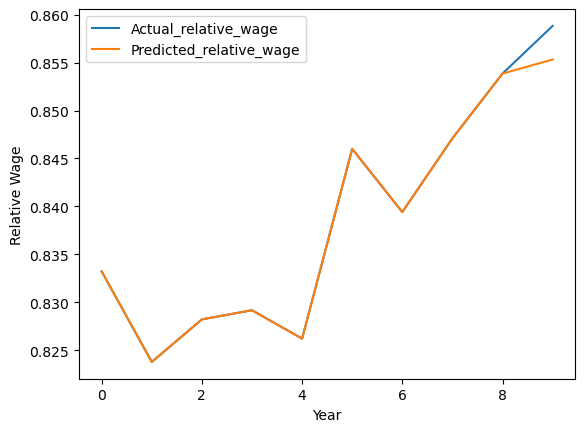

In [132]:
X_correct = data_france.to_numpy()
prediction_2021 = france_prediction.numpy()
X_2020 = X_correct[0, :9]
X_prediction_2021 = np.concatenate((X_2020, prediction_2021[0]))
plt.plot(X_correct[0], label='Actual_relative_wage')
plt.plot(X_prediction_2021, label='Predicted_relative_wage')
plt.xlabel('Year')
plt.ylabel('Relative Wage')
plt.legend()
plt.show()